##### IPython notebook setup

In [1]:
# Import path to source directory (bit of a hack in IPython)
import sys
import os
pwd = %pwd
sys.path.append(os.path.join(pwd, '../src'))

# And ensure modules are reloaded on any change (useful when developing code on the fly, etc)
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')

In [2]:
import pandas as pd
import numpy as np

In [30]:
from heur import FSA, ShootAndGo
from objfun import AirShip

# Tuning FSA on Air Ship example

### 1. Set up benchmark using Shoot & Go with ``maxeval = 1000``

In [80]:
def experiment_SG(hmaxs, M=1000, maxeval=1000):
    rows = []
    for hmax in hmaxs:
        for i in range(M):
            heur = ShootAndGo(AirShip(-100, 0, 800), maxeval=maxeval, hmax=hmax)
            row = heur.search()
            row['maxeval'] = maxeval
            row['hmax'] = hmax
            rows.append(row)
    return pd.DataFrame(rows)

In [105]:
%%time
hmaxs = np.array([0, 1, 5, 10, 50, 100, 200, 500, np.inf])
tab_sg = experiment_SG(hmaxs)

Wall time: 2min 15s


In [108]:
def mne(x):
    return np.mean(x[x<np.inf])

def rel(x):
    return np.NaN if np.size(x) == 0 else np.size(x[x<np.inf])/np.size(x)

def feo(x):
    return np.NaN if rel(x) == 0 else mne(x)/rel(x)

In [109]:
tab_sg.pivot_table(
    values=['neval'],
    index=['hmax'],
    aggfunc=[rel, mne, feo]
)

,rel,mne,feo
,neval,neval,neval
hmax,,,
0.000000,0.734,416.780654,567.821054
1.000000,0.706,408.194051,578.178542
5.000000,0.769,395.981795,514.930812
10.000000,0.768,391.128906,509.282430
50.000000,0.833,374.818727,449.962458
100.000000,0.867,343.043829,395.667623
200.000000,0.709,371.947814,524.609046
500.000000,0.601,364.143095,605.895333


``hmax=100`` yields the best search process. **Can we match that with properly configured FSA?**

## 2. Analysis of FEO for default configuration of FSA on AirShip

In [120]:
def experiment_FSA(T0s, M=1000, maxeval=1000, n0=100, alpha=2, r=0.5):
    rows = []
    for T0 in T0s:
        for i in range(M):
            heur = FSA(AirShip(-100, 0, 800), maxeval=maxeval, T0=T0, n0=n0, alpha=alpha, r=r)
            row = heur.search()
            row['maxeval'] = maxeval
            row['T0'] = T0
            row['n0'] = n0
            row['alpha'] = alpha
            row['r'] = r
            rows.append(row)
    return pd.DataFrame(rows)

In [169]:
%%time

T0s = np.array([0, 0.001, 0.01, 0.1, 1, 10, 100, np.inf])
# (T0 -> 0: FSA ~ Steepest Descent, T0 -> inf: FSA ~ Random Shooting)

tab_fsa = experiment_FSA(T0s=T0s, M=25)

Wall time: 6min 11s


In [170]:
tab_fsa.pivot_table(
    values=['neval'],
    index=['T0'],
    aggfunc=[rel, mne, feo]
)

,rel,mne,feo
,neval,neval,neval
T0,,,
0.000000,0.32,311.500000,973.437500
0.001000,0.28,251.142857,896.938776
0.010000,0.16,98.250000,614.062500
0.100000,0.20,92.000000,460.000000
1.000000,0.24,363.166667,1513.194444
10.000000,0.32,179.375000,560.546875
100.000000,0.24,253.833333,1057.638889
inf,0.16,541.750000,3385.937500


## 3. Tuning

In [198]:
def experiment_FSA_detail(T0=0.1, M=100, maxeval=1000, n0=100, alpha=2, r=0.5):
    rows = []
    step_data = pd.DataFrame(columns=['T', 'mut_size', 'x', 'f_x', 'y', 'f_y', 'jump'])

    for i in range(M):
        heur = FSA(AirShip(-100, 0, 800), maxeval=maxeval, T0=T0, n0=n0, alpha=alpha, r=r)
        row = heur.search()
        step_data = step_data.append(row['step_data'])
        print('neval=' + str(row['neval']))
    return step_data

In [223]:
step_data = experiment_FSA_detail(M=1)

neval=inf
Wall time: 3.66 s


In [224]:
# detailed optimization variable tracking:
step_data.head()

,T,mut_size,x,f_x,y,f_y,jump
0,0.099990,3,376,-19,[373],[-18.25],0
1,0.099960,0,376,-19,[376],[-19.0],0
2,0.099910,1,376,-19,[375],[-18.75],0
3,0.099840,0,376,-19,[376],[-19.0],0
4,0.099751,0,[377],-19,[377],[-19.25],1


In [128]:
# let's analyze the data graphically

import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')
import seaborn as sns

In [225]:
# this routine will plot two columns on two y axes (generally not a good idea)

def plot_compare(step_data, ax1_col, ax1_label, ax2_col, ax2_label):
    fig, ax1 = plt.subplots()

    k = step_data.index.values
    T = step_data[ax1_col]
    ax1.plot(k, T, 'b-')
    ax1.set_xlabel('Iteration (k)')
    ax1.set_ylabel(ax1_label, color='b')
    for tl in ax1.get_yticklabels():
        tl.set_color('b')

    ax2 = ax1.twinx()
    s2 = step_data[ax2_col]
    ax2.plot(k, s2, 'r.')
    ax2.set_ylabel(ax2_label, color='r')
    for tl in ax2.get_yticklabels():
        tl.set_color('r')

    plt.show()    

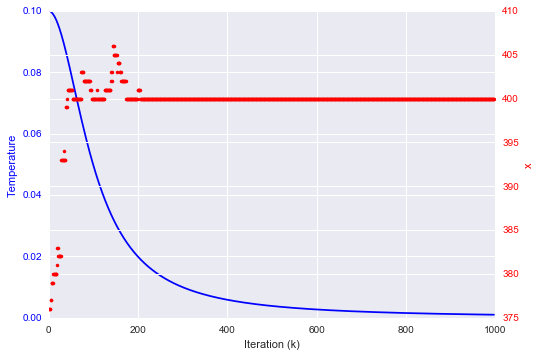

In [226]:
plot_compare(step_data, 'T', 'Temperature', 'x', 'x')

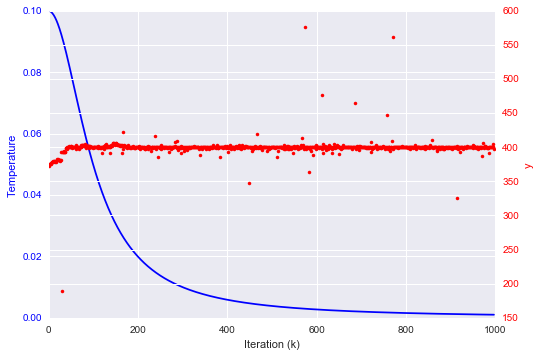

In [229]:
plot_compare(step_data, 'T', 'Temperature', 'y', 'y')

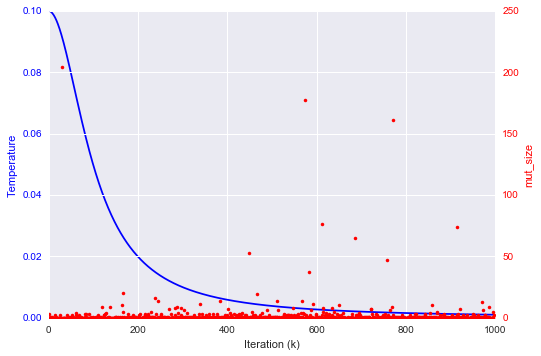

In [228]:
plot_compare(step_data, 'T', 'Temperature', 'mut_size', 'mut_size')

**Conclustion**: Mutation and thus neighbourhood is too small -> let's increase ``r``.

In [251]:
step_data = experiment_FSA_detail(M=1, r=10)

neval=inf


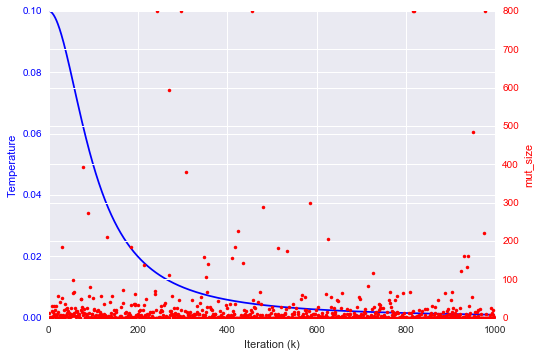

In [252]:
plot_compare(step_data, 'T', 'Temperature', 'mut_size', 'mut_size')

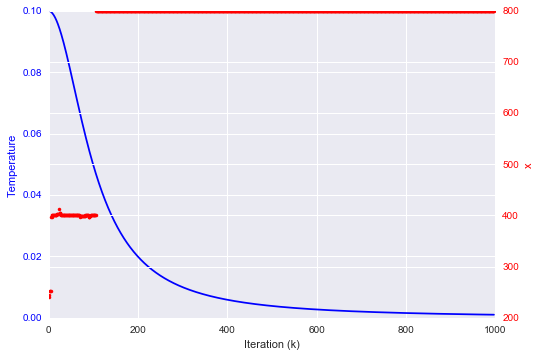

In [253]:
plot_compare(step_data, 'T', 'Temperature', 'x', 'x')

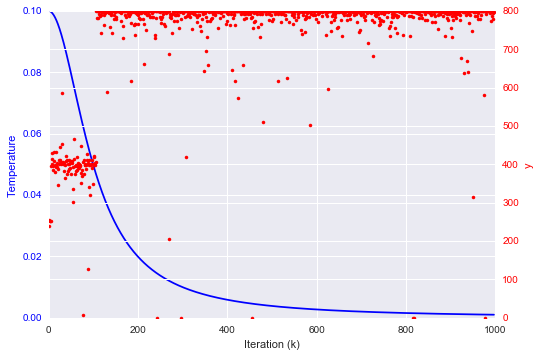

In [254]:
plot_compare(step_data, 'T', 'Temperature', 'y', 'y')

**Conclusion**: Mutation hit optimal basin of attraction ([0; 100]), but it was not accepted due to low temperature -> let's make the cooling slower.

In [300]:
step_data = experiment_FSA_detail(M=1, T0=10, n0=1000, r=10)

neval=829


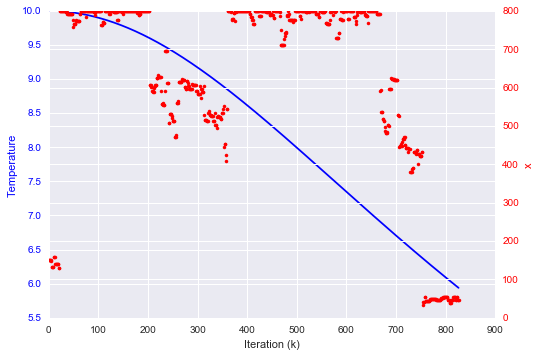

In [301]:
plot_compare(step_data, 'T', 'Temperature', 'x', 'x')

** ...and validate on larger sample:**

In [395]:
def experiment_FSA(T0s, rs, n0s, alphas, M=1000, maxeval=1000):
    rows = []
    for T0 in T0s:
        for n0 in n0s:
            for alpha in alphas:
                for r in rs:
                    for i in range(M):
                        heur = FSA(AirShip(-100, 0, 800), maxeval=maxeval, T0=T0, n0=n0, alpha=alpha, r=r)
                        row = heur.search()
                        row['maxeval'] = maxeval
                        row['T0'] = T0
                        row['n0'] = n0
                        row['alpha'] = alpha
                        row['r'] = r
                        rows.append(row)
    return pd.DataFrame(rows)

In [429]:
%%time
tab_fsa = experiment_FSA(T0s=np.array([10]), rs=np.array([10, 15, 20]), n0s=np.array([1000]), alphas=np.array([2]), M=1000)

Wall time: 1min 58s


In [430]:
tab_fsa.pivot_table(
    values=['neval'],
    index=['r'],
    aggfunc=[rel, mne, feo]
)

,rel,mne,feo
,neval,neval,neval
r,,,
10,0.685,255.072993,372.369332
15,0.750,287.461333,383.281778
20,0.799,297.604506,372.471221


**Final conclustion**: FEO was improved (by a small margin).

## By the way...

In [433]:
%%time
tab_fsa = experiment_FSA(T0s=np.array([10]), rs=np.array([10]), n0s=np.array([1000]), alphas=np.array([2]), M=1000, maxeval=100)

Wall time: 6.77 s


In [434]:
tab_fsa.pivot_table(
    values=['neval'],
    index=['r'],
    aggfunc=[rel, mne, feo]
)

,rel,mne,feo
,neval,neval,neval
r,,,
10,0.276,45.981884,166.601029


...if you look into ``20160301_Shoot_and_Go_analysis``, the best FEO for $\mathrm{SG}_{\infty}$ and ``maxeval=100`` was $284.53$.